In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Conv2D, Layer, Reshape, Dropout, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from sklearn import datasets
import sympy
import tqdm

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display
import glob
from PIL import Image
import datetime

2023-02-17 16:18:39.937157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 16:18:39.937194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-17 16:18:41.949317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-17 16:18:41.949357: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-17 16:18:41.949368: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2023-02-17 16:18:41.949544: I tensorflow/core/platform/cpu_featu

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

5


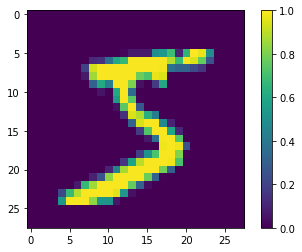

In [4]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [5]:
x_train_small = tf.image.resize(x_train, (2,2)).numpy()
x_test_small = tf.image.resize(x_test, (2,2)).numpy()

5


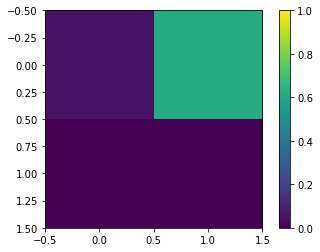

In [6]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [7]:
def resize_data(x, y, label, image_size):

    ''' Function scaling real data.
        
        Input:  image array, label array, image size, number of classes.    
        Output : list of tuple (image torch tensor, label torch tensor), 
                 list of image tensor. '''

    images_tuple = []
    images = []

    for t, l in zip(x, y):
        if l in label:
            t = tf.reshape(t, (image_size, image_size))
            t = t/16
            images_tuple.append((t, tf.convert_to_tensor(l, 1)))
            images.append(t)
    return images_tuple, images

In [8]:
_, imgs = resize_data(x_train_small, y_train, label = (0,), image_size = 2)

In [9]:
qubits = cirq.GridQubit.rect(1,5)
gen_n_layers = 4
observables = [cirq.Z(q) for q in qubits]

In [10]:
def real(qubits, symb):
    #symb = sympy.symbols('theta_1 theta_2 theta_3 theta_4 theta_5 theta_6 theta_7 theta_8 theta_9')

    u = cirq.Circuit() 
    u.append(cirq.H(qubits[0]))
    u.append(cirq.rx(symb[0]).on(qubits[0])) 
    u.append(cirq.ry(symb[2]).on(qubits[0]))
    u.append(cirq.rz(symb[2]).on(qubits[0]))

    return u

In [11]:
def one_qubit_rotation(qubit, symbols):
    '''
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    '''
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    '''
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    '''
    cnot_ops = [cirq.CNOT(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    return cnot_ops

def generator_circuit(qubits, n_layers):
    '''
    First qubit is ancillary.
    First layer represents quantum noise state vector |z>.

    p.s. We could add random rotation regarding to the encoding layer.
    '''

    # Number of qubits
    n_qubits = len(qubits)    

    # Sympy symbols for encoding layer
    enc_symbs = sympy.symbols(f'phi(0:{1})'+f'_(0:{n_qubits})')
    enc_symbs = np.asarray(enc_symbs).reshape((1, n_qubits))

    # Sympy symbols for variational layers
    var_symbs = sympy.symbols(f'theta(0:{3*(n_layers)*n_qubits})')
    var_symbs = np.asarray(var_symbs).reshape((n_layers, n_qubits, 3))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        if l == 0:
            #encoding layer
            circuit += cirq.Circuit(cirq.rx(enc_symbs[l, i])(q) for i, q in enumerate(qubits))

        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, var_symbs[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)

    return circuit, list(var_symbs.flat), list(enc_symbs.flat)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


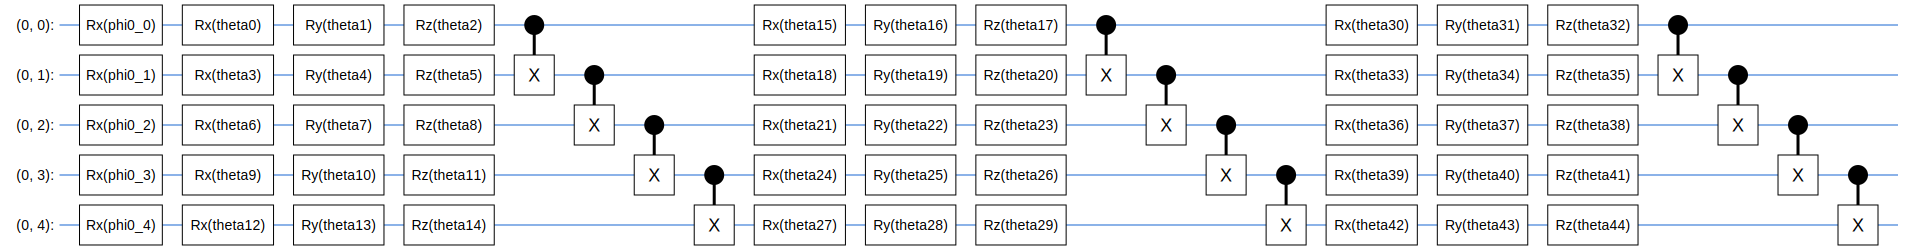

In [12]:
g, variational_params, encoder_params = generator_circuit(qubits = qubits, n_layers = 3) 
SVGCircuit(g)

In [13]:
class Generator(Layer):

    def __init__(self, qubits, gen_n_layers, observables, noise_batch_size, activation = 'linear', name = "Generator"):
        super(Generator, self).__init__()
        self.gen_n_layers = gen_n_layers
        self.qubits = qubits
        self.observables = observables
        self.activation = activation
        self.noise_batch_size = noise_batch_size

        self.circuit, self.var_symb, self.enc_symb = generator_circuit(qubits, self.gen_n_layers)
        
        self.tens_circuit = tfq.convert_to_tensor([self.circuit])

        self.symbols = [str(symb) for symb in self.enc_symb + self.var_symb]
        self.indices = tf.constant([self.symbols.index(a) for a in sorted(self.symbols)]) 

        #self.scaled_input = []

        self.state_layer = tfq.layers.State()
        self.expectation_layer = tfq.layers.Expectation()

        theta_init = tf.random_uniform_initializer(minval = 0.0, maxval = np.pi)
        self.theta = tf.Variable(initial_value=theta_init(shape=(1, len(self.var_symb)), dtype="float32"), trainable=True, name="thetas")

    # def build(self, input_shape):
        
        
    #     #print(theta_init)
    #     phi_init = tf.keras.initializers.ones()
    #     #print(phi_init)

    #     self.theta = self.add_weight(shape = (len(self.var_symb),), initializer = theta_init, name = "theta")
    #     self.phi = self.add_weight(shape = (len(self.enc_symb),), initializer = phi_init, name = "phi")    
       
    def call(self, inputs):

        #print(inputs)
        #print(self.theta)

        #inputs = tf.convert_to_tensor(inputs)
        #print('input: ', inputs)
        #batch_size = tf.gather(tf.shape(inputs), 0)
        #print('data:', batch_size)
        #params = tf.concat([self.phi, self.theta], axis = 0)
        #print('parameters:', self.params)
        #tiled_up_params = tf.tile(tf.expand_dims(self.theta, 0), [batch_size, 1])
        #print('tiled up params:', tiled_up_params)
        #for i in range(batch_size):
        #scaled_inputs = tf.einsum("i,ji->ji", self.phi, inputs)
        #print('scaled input:', scaled_inputs)
        #    self.scaled_input.append(scaled_inputs)

        #scaled_input_tensor = tf.convert_to_tensor(self.scaled_input), tf.squeeze(scaled_input_tensor, 1)

        #squashed_inputs = Activation(self.activation)()
        joined_params = tf.concat([inputs, self.theta], 1)
        #print('joined params: ', joined_params)
        #joined_params = tf.gather(joined_params, self.indices, axis = 1)
        #print('joined vars after', joined_params)

        states = self.state_layer(self.circuit, symbol_names = self.symbols, symbol_values = joined_params)
        #print('states: ', states)

        expectations = self.expectation_layer(self.circuit, symbol_names = self.symbols,
                                              operators = self.observables, symbol_values = joined_params)  
        #print('Observables', expectations)

        #probs = list(abs(x)**2 for x in states)

        return expectations#, probs#, self.circuit, self.symbols, joined_params       

In [14]:
# input_circuit_tensor = tfq.convert_to_tensor([g])
# y_appender = tfq.layers.AddCircuit()
# output_circuit_tensor = y_appender(input_circuit_tensor, append=g)

In [15]:
# class QuantumGen():

#     def __init__(self, qubits, gen_n_layers, observables):
#         super(QuantumGen, self).__init__()
        
#         self.gen_n_layers = gen_n_layers
#         self.qubits = qubits
#         self.observables = observables
#         self.noise_batch_size = 1
#         optimizer = Adam(0.001)        

#     def build_gen(self):
#         signal_input = Input(shape=(1, len(self.qubits)), dtype=tf.dtypes.float32, name = 'input')
#         gen_out = Generator(self.qubits, self.gen_n_layers, self.observables, self.noise_batch_size)([signal_input])

#         return Model(inputs = signal_input, outputs = gen_out)

In [16]:
n_qubits = 2
qubits = cirq.GridQubit.rect(n_qubits,n_qubits)
n_a_qubits = 1
gen_n_layers = 4
observables = [cirq.Z(q) for q in qubits]
n_generators = 4
batch_size = 8
noise_batch_size = 1

# Testing generator quantum circuit
inp = Input(shape=(n_qubits*n_qubits,))
z_noise = tf.random.normal([1,n_qubits*n_qubits]) * np.pi / 2
#print('Z noise: ', z_noise)

exp = Generator(qubits = qubits, gen_n_layers = gen_n_layers, observables = observables, noise_batch_size = noise_batch_size)(inp)

gen_model = Model(inp, exp)
gen_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 generator (Generator)       (1, 4)                    48        
                                                                 
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [17]:
#gen_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy())

In [18]:
# non_diff_op = tfq.get_expectation_op()
# linear_differentiator = tfq.differentiators.ParameterShift()
# # Get an expectation op, with this differentiator attached.
# op = linear_differentiator.generate_differentiable_op(analytic_op=non_diff_op)

#psums = tfq.convert_to_tensor([[cirq.Z(q) for q in qubits]])
with tf.GradientTape() as g:
    
    exp = Generator(qubits = qubits, gen_n_layers = gen_n_layers, observables = observables, noise_batch_size = noise_batch_size)(inp)

    gen_model = Model(inp, exp)

    #gen_model= Generator(qubits = qubits, gen_n_layers = gen_n_layers, observables = observables, noise_batch_size = noise_batch_size)
    expectations = gen_model(z_noise)
    # g.watch(values)
    # print('exp:', exp)
    # c = tfq.convert_to_tensor([circ])
    # symbol_names = tf.convert_to_tensor(symbols)   
    
    #expectations = op(c, symbol_names, values, psums)
    #print('expectation: ', expectations)
# This value is now computed via the ParameterShift rule
grads = g.gradient(expectations, gen_model.trainable_variables)
#grads

In [19]:
class discriminator(Model):
    def __init__(self):
        
        super(discriminator, self).__init__() 
        #self.disc_input_shape = disc_input_shape
        #self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        #self.input = Input(shape=self.disc_input_shape) 

        self.conv1 = Conv2D(5, (1,1), strides = (2, 2), padding = 'same')  
        self.conv2 = Conv2D(128, (1,1), strides = (2, 2), padding = 'same')
        self.dense = Dense(1)
              

    def call(self, input):
        
        #print('inp', input)
        
        x = self.conv1(input)
        #print('1', x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = self.conv2(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = self.dense(x)
        #print('fin', x)

        return tf.keras.activations.sigmoid(x)

In [20]:
inppp = tf.random.normal([1, 16, 1, 1])

disc = discriminator()

# a = x_train[0]
# a = tf.expand_dims(a, axis = 0)
# print(disc_net(a))
disc.build(input_shape=(1,n_qubits*n_qubits,1,1))
disc.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  10        
                                                                 
 conv2d_1 (Conv2D)           multiple                  768       
                                                                 
 dense (Dense)               multiple                  129       
                                                                 
Total params: 907
Trainable params: 907
Non-trainable params: 0
_________________________________________________________________


In [21]:
class Trainer():

    def __init__(self, x_train, gen_net, disc_net, gen_init_layer_size, z_dim, disc_input_shape, batch_size):
        super(Trainer, self).__init__()
        self.x_train = x_train
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.disc_input_shape = disc_input_shape
        self.gen_opt = tf.keras.optimizers.SGD(3e-1)
        self.disc_opt = tf.keras.optimizers.SGD(1e-2) 
        self.batch_size = batch_size      
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
        self.gen_net = gen_net 
        self.disc_net = disc_net  
        #self.writer = writer  
        #self.logging= logging  
        #self.log_dir = log_dir

        
    
    def gen_loss(self, fake_out):
        return self.loss(tf.ones_like(fake_out), fake_out)


    def disc_loss(self, img, fake_out):

        real_loss = self.loss(tf.ones_like(img), img)
        fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)

        total_loss = real_loss + fake_loss
        return total_loss   


    def generate_and_save_images(self, model, epoch, test_input):
        
        predictions = model(test_input, training=False)

        plt.figure(figsize=(8, 8))

        for i, image in enumerate(predictions, 1):
            try:
                plt.subplot(4, 4, i)
                plt.imshow(image[:, :, 0], cmap='gray')
            except ValueError:
                break       
        
        plt.savefig(self.log_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


    def train_step(self, image):

        noise = tf.random.normal([self.batch_size, self.z_dim])
        #print(noise.shape)
        #image = tf.reshape(image, (1,self.z_dim,1,1))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.gen_net(noise, training=True)

            real_out = self.disc_net(tf.reshape(image, (1,self.z_dim,1,1)), training = True)
            fake_out = self.disc_net(tf.reshape(generated_images, (1,self.z_dim,1,1)), training = True)

            gen_loss = self.gen_loss(fake_out)
            disc_loss = self.disc_loss(real_out, fake_out)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.gen_net.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.disc_net.trainable_variables)

        #print('Grad gen: ', gradients_of_generator)
        #print('Grad disc: ', gradients_of_discriminator)

        self.gen_opt.apply_gradients(zip(gradients_of_generator, self.gen_net.trainable_variables))
        self.disc_opt.apply_gradients(zip(gradients_of_discriminator, self.disc_net.trainable_variables))
            
        return gen_loss, disc_loss


    def learn(self, epochs):

        self.g_loss = []
        self.d_loss = []
        self.g_loss_tot, self.d_loss_tot = [], []


        for epoch in range(epochs):

            print(f'EPOCH {epoch+1}')

            i = 0

            for _, batch_img in enumerate(self.x_train):

                gl, dl = self.train_step(batch_img)                

                i += 1

                self.g_loss.append(gl)
                
                self.d_loss.append(dl)

            self.g_loss_tot.append(np.mean(self.g_loss))
            self.d_loss_tot.append(np.mean(self.d_loss))


        
            # produce images 
            #display.clear_output(wait=True)
            #self.generate_and_save_images(self.gen_net, epoch + 1, tf.random.normal([self.batch_size, self.z_dim]))  

            
            
        
        # print(len(self.g_loss))
        # plt.figure(figsize=(15, 8))
        # plt.plot(np.arange(len(self.g_loss)), self.g_loss, color = 'Red', label = 'Generator Loss')
        # plt.plot(np.arange(len(self.d_loss)), self.d_loss, color = 'Blue', label = 'Discriminator Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend(loc = 'upper right')
        # plt.show()

In [22]:
z_dim = 4
batch_size = 1
buffer_size = 360
train_dataset = tf.data.Dataset.from_tensor_slices(imgs[:300]).shuffle(buffer_size).batch(batch_size)
epochs = 20

# for elem in train_dataset:
#     #print(elem.shape)

In [23]:
exp = Generator(qubits = qubits, gen_n_layers = gen_n_layers, observables = observables, noise_batch_size = noise_batch_size)(inp)

gen_net = Model(inp, exp)
disc_net = discriminator()

trainer = Trainer(x_train=train_dataset, gen_net=gen_net, disc_net=disc_net, gen_init_layer_size=(1,4), z_dim=z_dim, disc_input_shape=(1,4,1,1), batch_size=batch_size)

trainer.learn(epochs)

EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20


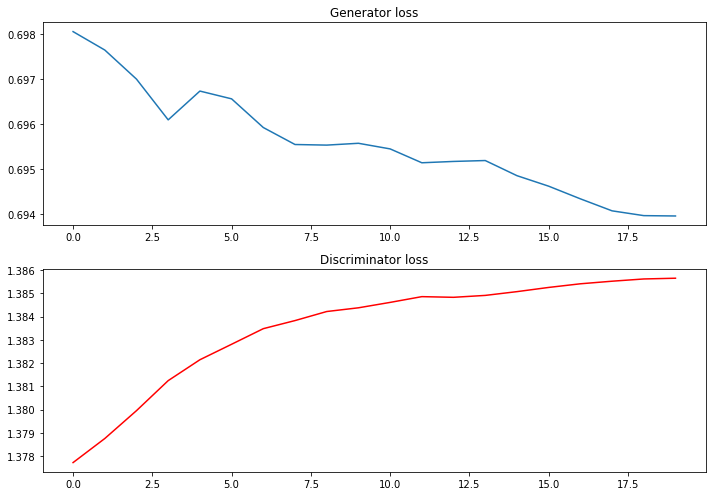

In [24]:
figure, axis = plt.subplots(2,1, figsize=(10,7))

axis[0].plot(np.arange(len(trainer.g_loss_tot)), trainer.g_loss_tot)
axis[0].set_title('Generator loss')
axis[1].plot(np.arange(len(trainer.d_loss_tot)), trainer.d_loss_tot, label='Disc loss', color='red')
axis[1].set_title("Discriminator loss")

figure.tight_layout()
plt.show()